# Traffic Light Detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing.image import array_to_img, img_to_array
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


## CNN

In [2]:
img_width, img_height = 150, 150

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

In [3]:
K.image_data_format()

'channels_last'

### Train Model

In [4]:
batch_size = 16
epochs = 100

In [5]:
train_datagen = ImageDataGenerator(
    data_format='channels_last',
    rescale=1./255,
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [6]:
train_generator = train_datagen.flow_from_directory(
    directory='data/train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 8840 images belonging to 4 classes.


In [7]:
nb_class = train_generator.num_class
classes = train_generator.class_indices
nb_train_samples = train_generator.samples

In [8]:
nb_train_samples

8840

In [9]:
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [10]:
%%time

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs)

Epoch 1/100
552/552 [==============================] - 245s - loss: 1.0431 - acc: 0.5599   
Epoch 2/100
552/552 [==============================] - 179s - loss: 0.7194 - acc: 0.6967   
Epoch 3/100
552/552 [==============================] - 112s - loss: 0.6058 - acc: 0.7447   
Epoch 4/100
552/552 [==============================] - 111s - loss: 0.5309 - acc: 0.7775   
Epoch 5/100
552/552 [==============================] - 111s - loss: 0.4876 - acc: 0.7972   
Epoch 6/100
552/552 [==============================] - 111s - loss: 0.4380 - acc: 0.8193   - ETA: 0s - loss: 0.4384 - acc: 0.819
Epoch 7/100
552/552 [==============================] - 112s - loss: 0.3899 - acc: 0.8410   
Epoch 8/100
552/552 [==============================] - 112s - loss: 0.3598 - acc: 0.8531   
Epoch 9/100
552/552 [==============================] - 112s - loss: 0.3403 - acc: 0.8610   
Epoch 10/100
552/552 [==============================] - 111s - loss: 0.3045 - acc: 0.8749   
Epoch 11/100
552/552 [====================

552/552 [==============================] - 107s - loss: 0.0783 - acc: 0.9755   
Epoch 88/100
552/552 [==============================] - 108s - loss: 0.0627 - acc: 0.9771   
Epoch 89/100
552/552 [==============================] - 108s - loss: 0.0625 - acc: 0.9780   
Epoch 90/100
552/552 [==============================] - 108s - loss: 0.0703 - acc: 0.9767   - ETA: 0s - loss: 0.0707 - acc: 0.
Epoch 91/100
552/552 [==============================] - 108s - loss: 0.0617 - acc: 0.9785   
Epoch 92/100
552/552 [==============================] - 108s - loss: 0.0640 - acc: 0.9796   
Epoch 93/100
552/552 [==============================] - 108s - loss: 0.0730 - acc: 0.9732   
Epoch 94/100
552/552 [==============================] - 109s - loss: 0.0653 - acc: 0.9779   
Epoch 95/100
552/552 [==============================] - 108s - loss: 0.0624 - acc: 0.9770   
Epoch 96/100
552/552 [==============================] - 108s - loss: 0.0609 - acc: 0.9758   
Epoch 97/100
552/552 [===========================

### Save Model

In [12]:
model_name = 'model_keras_v2.0.8_%d_%d_%d_%d' % (nb_train_samples, batch_size, 
                                              epochs, int(time() * 1e6))
model_name

'model_keras_v2.0.8_8840_16_100_1507793881247232'

In [13]:
model.save_weights(model_name + '.h5') 

In [14]:
model_json = model.to_json()

In [15]:
with open(model_name + '.json', "w") as json_file:
    json_file.write(model_json)

### Test Model

In [16]:
test_datagen = ImageDataGenerator(
    data_format='channels_last',
    rescale=1./255)

test_generator = train_datagen.flow_from_directory(
    'data/loop_with_traffic_light/training',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 1151 images belonging to 4 classes.


In [17]:
%%time

i = 0
for images in test_generator:
    print(images[0].shape)
    predictions = model.predict(images[0])
    i += 1
    if i > 0:
        break

(16, 150, 150, 3)
CPU times: user 568 ms, sys: 32 ms, total: 600 ms
Wall time: 1.36 s


### Visualize Examples

In [18]:
class_to_idx = train_generator.class_indices
class_to_idx

{'green': 0, 'red': 1, 'unknown': 2, 'yellow': 3}

#### Overlay Color Labels

In [19]:
red = Image.new('RGB', (img_width, 10), (255, 0, 0))
green = Image.new('RGB', (img_width, 10), (0, 255, 0))
yellow = Image.new('RGB', (img_width, 10), (244, 219, 36))
unknown = Image.new('RGB', (img_width, 10), (0, 0, 0))

In [20]:
idx_to_class = {}
idx_to_overlay = {}

In [21]:
for k, v in class_to_idx.items():
    idx_to_class[v] = k
    idx_to_overlay[v] = eval(k)

In [22]:
idx_to_class

{0: 'green', 1: 'red', 2: 'unknown', 3: 'yellow'}

In [23]:
idx_to_overlay

{0: <PIL.Image.Image image mode=RGB size=150x10 at 0x7F475534C200>,
 1: <PIL.Image.Image image mode=RGB size=150x10 at 0x7F4755759D88>,
 2: <PIL.Image.Image image mode=RGB size=150x10 at 0x7F475576C248>,
 3: <PIL.Image.Image image mode=RGB size=150x10 at 0x7F4755759DD0>}

#### Sample Images from Several Sources

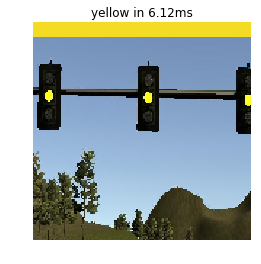

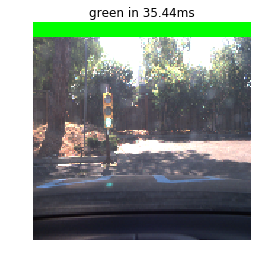

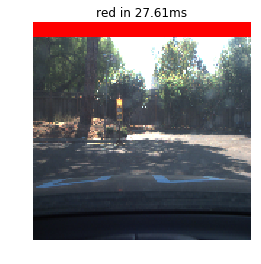

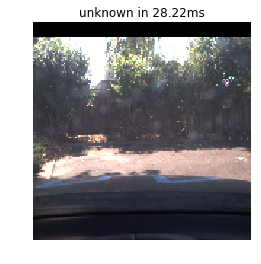

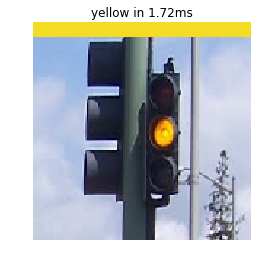

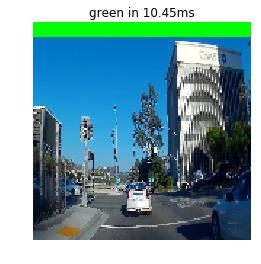

CPU times: user 700 ms, sys: 588 ms, total: 1.29 s
Wall time: 553 ms


In [26]:
%%time

images = [
    load_img('data/simulator_traffic_light/training/yellow/sim-1506291430325470.jpeg'),
    load_img('data/loop_with_traffic_light/training/green/1503524655778037037.png'),
    load_img('data/just_traffic_light/training/red/1503524771576164202.png'),
    load_img('data/just_traffic_light/training/unknown/1503524776309465909.png'),
    load_img('data/internet/yellow/yellow-internet-0013.jpg'),
    load_img('data/dashcam/green/2017_0929_172227_530-000051.jpg'),
]

for image in images:
    
    # Pipeline start time
    start = time()
    
    # Resize to 150x150
    img = image.resize((img_width, img_height))

    # Normalized numpy array with shape (150, 150, 3)
    x = img_to_array(img, data_format='channels_last') / 255.

    # Numpy array with shape (1, 150, 150, 3)
    x = x.reshape((1,) + x.shape)
    
    prediction = model.predict(x)
    
    pred_idx = np.argmax(prediction[0])
    img.paste(idx_to_overlay[pred_idx], (0, 0))
    
    # Pipeline end prediction time
    end = time()
    
    plt.imshow(img)
    plt.title('%s in %4.2fms' % (idx_to_class[pred_idx], (end - start) * 1000))
    plt.axis('off')
    plt.show()